# Apply RNA2seg on spatial data 

This notebook presents the workflow for applying RNA2Seg on Zarr-saved dataset. The process is structured into five main steps:

- **Create training patches** - Extract patches of a reasonable size to process efficiently (saved in the Zarr file). 
- **Initialize an RNA2segDataset**
- **Initialize a model RNA2Seg**
- **Run segmentation**: RNA2Seg is applied to the dataset to generate cell segmentations, which are then saved in a Zarr format.
- **Visualize segmentation**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import spatialdata as sd
from pathlib import Path

## Step 1: Create patches from Zarr files

In this step, the dataset (image + transcripts) is divided into patches of size `patch_width × patch_width` with an overlap of `patch_overlap`. This allows processing images of a manageable size while preserving spatial continuity.  

**Process** 
- The dataset, stored in Zarr format, is loaded.  
- Patches coordinates are saved as a `Shape` in the zarr: `sopa_patches_rna2seg_[patch_width]_[patch_overlap]`. 
- A `.rna2seg` directory is created to store the transcript data corresponding to each patch.  
- The transcript information for each patch is saved in CSV format for further processing.  


In [2]:
from rna2seg.dataset_zarr.patches import create_patch_rna2seg

### load sdata and set path parameters 
merfish_zarr_path = "/Users/alice/Documents/data/Cell_Segmentation/test_mouse_ileum.zarr"
sdata = sd.read_zarr(merfish_zarr_path)
image_key = "staining_z3"
points_key = "transcripts"
patch_width = 1200
patch_overlap = 150
min_transcripts_per_patch = 0
folder_patch_rna2seg = Path(merfish_zarr_path) / ".rna2seg"

### create patch in the sdata and precompute transcipt.csv for each patch with sopa
create_patch_rna2seg(sdata,
                    image_key=image_key,
                    points_key=points_key,
                    patch_width=patch_width,
                    patch_overlap=patch_overlap,
                    min_transcripts_per_patch=min_transcripts_per_patch,
                    folder_patch_rna2seg = folder_patch_rna2seg,
                    overwrite = True)
print(sdata)

[INFO] (sopa.patches.patches) 81 patches were saved in sdata['sopa_patches_rna2seg_1200_150']


[########################################] | 100% Completed | 15.50 ss
SpatialData object, with associated Zarr store: /Users/alice/Documents/data/Cell_Segmentation/test_mouse_ileum.zarr
├── Images
│     └── 'staining_z3': DataTree[cyx] (5, 9000, 9000), (5, 4500, 4500), (5, 2250, 2250), (5, 1125, 1125), (5, 562, 562)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
└── Shapes
      ├── 'Cellbound1': GeoDataFrame shape: (3258, 1) (2D shapes)
      ├── 'Cellbound1_consistent_with_nuclei': GeoDataFrame shape: (1007, 1) (2D shapes)
      ├── 'Cellbound1_consistent_without_nuclei': GeoDataFrame shape: (2239, 1) (2D shapes)
      ├── 'DAPI': GeoDataFrame shape: (2377, 1) (2D shapes)
      ├── 'DAPI_consistent_in_cell': GeoDataFrame shape: (1007, 1) (2D shapes)
      ├── 'DAPI_consistent_not_in_cell': GeoDataFrame shape: (1370, 1) (2D shapes)
      ├── 'rna2seg_test': GeoDataFrame shape: (3617, 1) (2D shapes)
      ├── 'rna2seg_test_v0': GeoDataFrame shape:

## Step 2: Initialize a RNA2segDataset

In [3]:
import albumentations as A
from rna2seg.dataset_zarr import RNA2segDataset

transform_resize  = A.Compose([
    A.Resize(width=512, height=512, interpolation=cv2.INTER_NEAREST),
])

dataset = RNA2segDataset(
    sdata=sdata,
    channels_dapi= ["DAPI"],
    channels_cellbound=["Cellbound1"],
    patch_width = patch_width,
    patch_overlap = patch_overlap,
    gene_column="gene",
    transform_resize = transform_resize,
    patch_dir=folder_patch_rna2seg
)

default shape_patch_key set to sopa_patches_rna2seg_1200_150
100%|██████████| 81/81 [00:01<00:00, 45.07it/s]
Number of valid patches: 64


## Step 3: Initialize a model RNA2seg

By default, the trained RNA2seg model is downloaded from Hugging Face. You can also specify `pretrained_model` to use your own RNA2seg model.

In [4]:
from rna2seg.models import RNA2seg

device = "mps"
rna2seg = RNA2seg(
    device,
    net='unet',
    flow_threshold = 0.9,
    cellbound_flow_threshold = 0.4,
)

No module named 'vmunet'
VMUnet not loaded
initiaisation of CPnet
Initiaisation of ChannelInvariantNet


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 22192.08it/s]

Loading weights from /Users/alice/.cache/huggingface/hub/models--aliceblondel--RNA2seg/snapshots/26f9afe181ea58f808ecd9c0732c327936020b18/rna2seg.pt


## Step 4: Run segmentation 

We will run the segmentation on the entire dataset and save the results as a shape in the Zarr file.

In [5]:
from tqdm import tqdm
from rna2seg.utils import save_shapes2zarr

segmentation_shape_name = "test"
for i in tqdm(range(len(dataset))):
    input_dict = dataset[i]
    rna2seg.run(
        path_temp_save=folder_patch_rna2seg,
        input_dict=input_dict
    )

save_shapes2zarr(dataset, segmentation_shape_name)

  2%|▏         | 1/64 [00:01<01:53,  1.80s/it]

89 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
  3%|▎         | 2/64 [00:03<01:41,  1.63s/it]

73 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
  5%|▍         | 3/64 [00:04<01:23,  1.37s/it]

56 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
  6%|▋         | 4/64 [00:06<01:33,  1.56s/it]

90 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
  8%|▊         | 5/64 [00:07<01:30,  1.54s/it]

92 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
  9%|▉         | 6/64 [00:09<01:27,  1.51s/it]

82 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 11%|█         | 7/64 [00:09<01:13,  1.28s/it]

40 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 12%|█▎        | 8/64 [00:10<01:00,  1.08s/it]

26 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 14%|█▍        | 9/64 [00:11<01:03,  1.16s/it]

75 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 16%|█▌        | 10/64 [00:13<01:12,  1.34s/it]

83 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 17%|█▋        | 11/64 [00:15<01:15,  1.43s/it]

80 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 19%|█▉        | 12/64 [00:17<01:28,  1.70s/it]

105 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 20%|██        | 13/64 [00:19<01:25,  1.67s/it]

113 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 22%|██▏       | 14/64 [00:20<01:15,  1.52s/it]

85 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 23%|██▎       | 15/64 [00:21<01:07,  1.37s/it]

62 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 25%|██▌       | 16/64 [00:22<00:58,  1.23s/it]

46 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 27%|██▋       | 17/64 [00:23<01:02,  1.32s/it]

89 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 28%|██▊       | 18/64 [00:25<01:07,  1.46s/it]

74 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 30%|██▉       | 19/64 [00:26<01:04,  1.42s/it]

76 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 31%|███▏      | 20/64 [00:29<01:10,  1.61s/it]

105 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 33%|███▎      | 21/64 [00:30<01:07,  1.57s/it]

84 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 34%|███▍      | 22/64 [00:31<00:56,  1.35s/it]

40 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 36%|███▌      | 23/64 [00:32<00:49,  1.21s/it]

54 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 38%|███▊      | 24/64 [00:33<00:48,  1.20s/it]

57 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 39%|███▉      | 25/64 [00:36<01:03,  1.62s/it]

113 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 41%|████      | 26/64 [00:38<01:11,  1.89s/it]

102 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 42%|████▏     | 27/64 [00:40<01:06,  1.79s/it]

70 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 44%|████▍     | 28/64 [00:40<00:54,  1.52s/it]

37 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 45%|████▌     | 29/64 [00:42<00:48,  1.37s/it]

51 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 47%|████▋     | 30/64 [00:43<00:45,  1.34s/it]

45 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 48%|████▊     | 31/64 [00:44<00:40,  1.23s/it]

55 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 50%|█████     | 32/64 [00:46<00:51,  1.61s/it]

116 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 52%|█████▏    | 33/64 [00:48<00:53,  1.73s/it]

94 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 53%|█████▎    | 34/64 [00:50<00:49,  1.66s/it]

75 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 55%|█████▍    | 35/64 [00:51<00:44,  1.55s/it]

67 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 56%|█████▋    | 36/64 [00:52<00:40,  1.45s/it]

60 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 58%|█████▊    | 37/64 [00:54<00:42,  1.57s/it]

76 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 59%|█████▉    | 38/64 [00:55<00:36,  1.40s/it]

46 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 61%|██████    | 39/64 [00:57<00:35,  1.42s/it]

76 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 62%|██████▎   | 40/64 [00:59<00:43,  1.82s/it]

120 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 64%|██████▍   | 41/64 [01:01<00:43,  1.88s/it]

77 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 66%|██████▌   | 42/64 [01:03<00:37,  1.70s/it]

61 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 67%|██████▋   | 43/64 [01:05<00:38,  1.85s/it]

97 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 69%|██████▉   | 44/64 [01:07<00:36,  1.80s/it]

89 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 70%|███████   | 45/64 [01:09<00:36,  1.94s/it]

97 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 72%|███████▏  | 46/64 [01:12<00:39,  2.21s/it]

102 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 73%|███████▎  | 47/64 [01:14<00:40,  2.36s/it]

117 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 75%|███████▌  | 48/64 [01:16<00:34,  2.16s/it]

83 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 77%|███████▋  | 49/64 [01:18<00:29,  1.96s/it]

77 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 78%|███████▊  | 50/64 [01:19<00:26,  1.89s/it]

89 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 80%|███████▉  | 51/64 [01:21<00:22,  1.69s/it]

65 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 81%|████████▏ | 52/64 [01:21<00:17,  1.47s/it]

51 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 83%|████████▎ | 53/64 [01:23<00:14,  1.35s/it]

60 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 84%|████████▍ | 54/64 [01:25<00:15,  1.58s/it]

103 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 86%|████████▌ | 55/64 [01:27<00:16,  1.80s/it]

115 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 88%|████████▊ | 56/64 [01:28<00:12,  1.55s/it]

55 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 89%|████████▉ | 57/64 [01:30<00:11,  1.65s/it]

94 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 91%|█████████ | 58/64 [01:31<00:09,  1.54s/it]

86 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 92%|█████████▏| 59/64 [01:32<00:06,  1.31s/it]

44 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 94%|█████████▍| 60/64 [01:33<00:04,  1.13s/it]

39 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 95%|█████████▌| 61/64 [01:33<00:03,  1.06s/it]

52 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 97%|█████████▋| 62/64 [01:36<00:02,  1.41s/it]

97 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
 98%|█████████▊| 63/64 [01:38<00:01,  1.59s/it]

109 cells detected


[INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
100%|██████████| 64/64 [01:39<00:00,  1.56s/it]


95 cells detected


100%|██████████| 64/64 [00:00<00:00, 1253.46it/s]


len(list_all_cells) 4933


Resolving conflicts: 100%|██████████| 9422/9422 [00:00<00:00, 10630.06it/s]

Added 3617 cell boundaries in sdata['rna2seg_test']


## Step 5: Visualize segmentation

Now, we visualize the results.
The following code extracts and plots three images: RNA transcripts, a selected staining image, and the corresponding segmentation.
Ensure that `staining_id` is valid to avoid indexing errors, and check that `bounds` are within dataset limits.

Get RNA image ...
Get image ...
Get segmentation image ...
Get image ...


100%|██████████| 58/58 [00:00<00:00, 74.62it/s] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


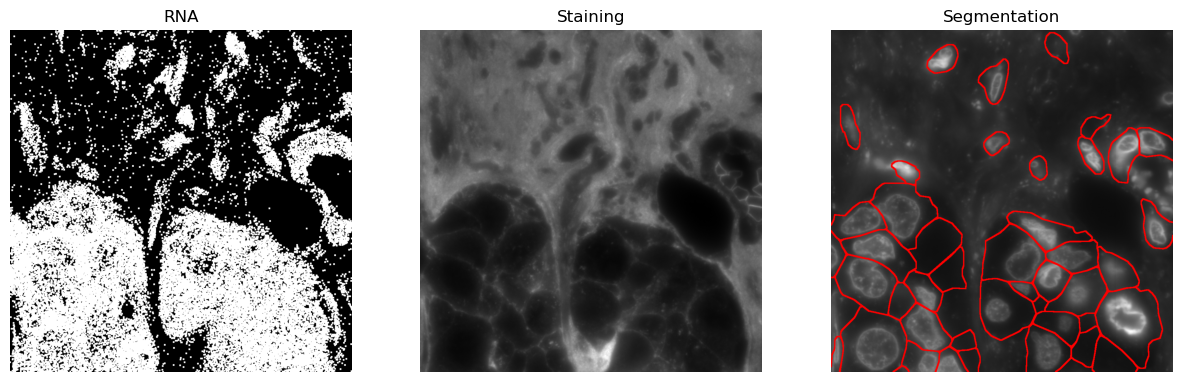

In [6]:
import matplotlib.pyplot as plt

# Parameters
key_segmentation="rna2seg_test"
bounds = [2000, 3000, 3000, 4000,] # xmin, ymin, xmax, ymax
staining_id = 1 # Staining to plot

# Get images
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)
seg = dataset.get_segmentation_img(bounds, key_cell=key_segmentation)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rna)
axes[0].set_title("RNA")
axes[0].axis("off")

axes[1].imshow(image[staining_id], cmap="grey")
axes[1].set_title("Staining")
axes[1].axis("off")

axes[2].imshow(seg)
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.show()
